In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import math

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("ab_data.csv")

In [3]:
df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [4]:
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
from math import ceil

%matplotlib inline

In [5]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [6]:
# We will minimum 4720 observations for each group

effect_size = sms.proportion_effectsize(0.13, 0.15)

required_s = sms.NormalIndPower().solve_power(effect_size, power=0.8, alpha=0.05, ratio=1)                                                  

required_s = ceil(required_s)                       

required_s

4720

In [7]:
df.describe(include='all').T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
user_id,294478.0,NaN,NaN,NaN,787974.124733,91210.823776,630000.0,709032.25,787933.5,866911.75,945999.0
timestamp,294478,294478,2017-01-21 22:11:48.556739,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
group,294478,2,treatment,147276,NaN,NaN,NaN,NaN,NaN,NaN,NaN
landing_page,294478,2,old_page,147239,NaN,NaN,NaN,NaN,NaN,NaN,NaN
converted,294478.0,NaN,NaN,NaN,0.119659,0.324563,0.0,0.0,0.0,0.0,1.0


In [8]:
# First, let's check if any user has been sampled multiple times.

session_counts = df['user_id'].value_counts(ascending=False)
dupl_users = session_counts[session_counts > 1].count()

dupl_users

3894

In [60]:
df_no_dups["user_id"].nunique()

286690

In [34]:
df_no_dups = df.drop_duplicates(subset=["user_id"], keep=False)

In [35]:
control_group = df_no_dups[df_no_dups['group']=='control'].sample(n=required_s, random_state=22)

In [36]:
pd.crosstab(control_group['group'], control_group['landing_page'])

landing_page,old_page
group,
control,4720


In [37]:
treatment_group = df_no_dups[df_no_dups['group']=='treatment'].sample(n= required_s, random_state=22)

In [38]:
pd.crosstab(treatment_group['group'], treatment_group['landing_page'])

landing_page,new_page
group,
treatment,4720


In [39]:
ab_test = pd.concat([control_group,treatment_group], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test.head()

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0


In [55]:
conversion_rates = pd.concat(
    [
        ab_test.groupby('group')['converted'].apply('mean').rename("CVR"),
        ab_test.groupby('group')['converted'].apply('std').rename("STD"),
        ab_test.groupby('group')['converted'].apply(
            lambda x: round(np.std(x)/np.sqrt(required_s), 3)
        ).rename("STDErr"),
        ab_test.groupby('group')['converted'].apply('count').rename("count"),
        ab_test.groupby('group')['converted'].apply('sum').rename("converted")
    ],
    axis=1
)
m_0, std_0, count_0 = conversion_rates[["CVR", "STD", "count"]].loc["control"].values
m_1, std_1, count_1 = conversion_rates[["CVR", "STD", "count"]].loc["treatment"].values
conversion_rates

,CVR,STD,STDErr,count,converted
group,,,,,
control,0.123305,0.328822,0.005,4720,582
treatment,0.125636,0.331473,0.005,4720,593


In [41]:
def get_ztats_pvalue(m_0, m_1, std_0, std_1, count_0, count_1, alpha = 0.05):
    standard_norm = stats.norm(0, 1)
    z_alpha = standard_norm.ppf(alpha)
    z_alpha
    Zstat = (m_0 - m_1)/np.sqrt( (pow(std_1,2)/count_1) + (pow(std_0, 2)/count_0) )
    p_value = stats.norm.sf(abs(Zstat))*2
    return Zstat, p_value

def get_confidence_interval(m_0, count_0):
    margin_95confidence = np.sqrt( (m_0 * (1 - m_0))/ count_0) * 2
    CI = [round(m_0 - margin_95confidence, 3), round(m_0 + margin_95confidence, 3)]
    return CI, margin_95confidence


In [42]:
CI_0 = get_confidence_interval(m_0, count_0)
CI_1 = get_confidence_interval(m_1, count_1)
print(f"""
CI 95% for control group : {CI_0[0]}
CI 95% for treatment treatment : {CI_1[0]}
""")


CI 95% for control group : [0.114, 0.133]
CI 95% for treatment treatment : [0.116, 0.135]



In [43]:
def get_all_stats_two_sided_test(m_0, m_1, std_0, std_1, count_0, count_1, alpha=0.05):
    zstat, p_value = get_ztats_pvalue(m_0, m_1, std_0, std_1, count_0, count_1)

    CI_0 = get_confidence_interval(m_0, count_0)
    CI_1 = get_confidence_interval(m_1, count_1)
    print(f"z-stat: {zstat}")
    print(f"p-value: {p_value}")
    print(f"CI 95% for control group : {CI_0[0]}")
    print(f"CI 95% for treatment treatment : {CI_1[0]}")

    if p_value >= alpha or p_value <= -alpha:
        print(f"For a confidence of {1- alpha}% we can not reject the Null hypothesis")
        print("There is no evidence that Control and Treatment distributions are not the same.")
    else:
        print(f"For a confidence of {1- alpha}% we reject the Null hypothesis, Control and Treatment distributions are different")
              
        
    

In [44]:
from scipy import stats
get_all_stats_two_sided_test(m_0, m_1, std_0, std_1, count_0, count_1, alpha=0.05)

z-stat: -0.34292173708042856
p-value: 0.7316573383898273
CI 95% for control group : [0.114, 0.133]
CI 95% for treatment treatment : [0.116, 0.135]
For a confidence of 0.95% we can not reject the Null hypothesis
There is no evidence that Control and Treatment distributions are not the same.


In [51]:
from collections import namedtuple
input_stats = {"control": {"m":m_0, "std": std_0, "count": count_0}, "treatment": {"m": m_1, "std":std_1, "count": count_1}}
Rating = namedtuple('Rating', ['mu', 'sigma'])
def visualise_distribution(**kwargs):
  fig = go.Figure()
  min_x = min([r.mu-4*r.sigma for r in kwargs.values()])
  max_x = max([r.mu+4*r.sigma for r in kwargs.values()])
  x = np.arange(min_x, max_x, 0.001)
  for key, value in kwargs.items():
      y = stats.norm.pdf(x, value.mu, value.sigma)
      fig.add_trace(go.Scatter(x=x, y=y, mode='lines', fill='tozeroy', name=key))
      fig.add_vline(x=2*value.sigma, line_width=1, annotation_text="95% confidence", line_dash="dash", line_color="green")
  return fig

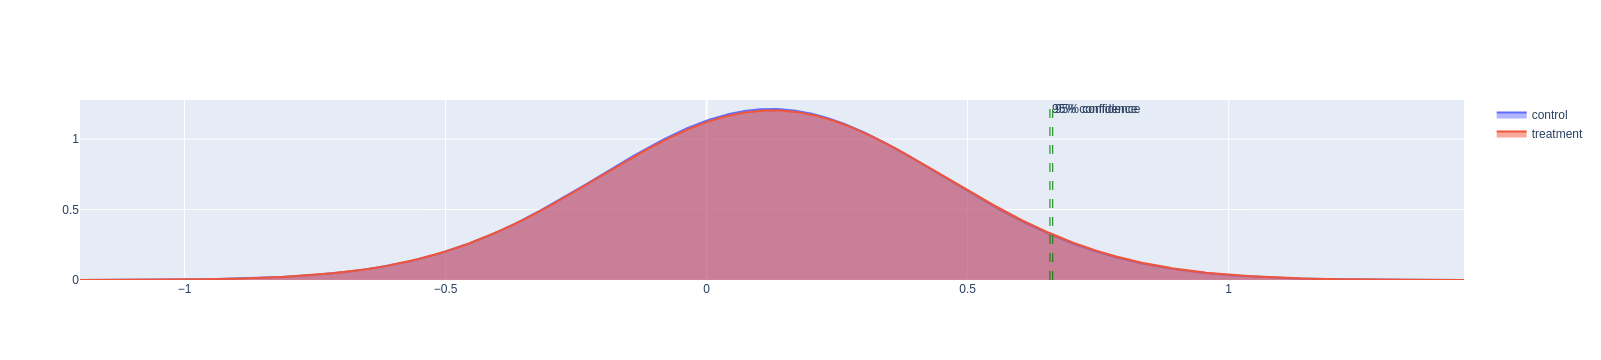

In [52]:
input_visualization= {}
import plotly.graph_objects as go

for group in input_stats:
    input_visualization[group]= Rating(
            input_stats[group]["m"],
            input_stats[group]["std"]
    )
    fig = visualise_distribution(**input_visualization)
fig.show()

In [69]:
import itertools 
list(itertools.combinations(["control", "treatment", "treatment2"], r=2))


[('control', 'treatment'),
 ('control', 'treatment2'),
 ('treatment', 'treatment2')]